<a href="https://colab.research.google.com/github/jaxckle/Insprit_AI_2025_Learning/blob/main/Jaxon_AlgorithmicJustice_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="red"><h1><b><u>MAKE A COPY OF THIS NOTEBOOK SO YOUR EDITS ARE SAVED</u></b></h1></font>


---
---
# 🏛️***Algorithmic Justice Section 2: Fairness***


*by Trenton Chang and Lindsay Sanneman*

In the second of this series of notebooks, we'll be exploring various definitions of fairness in AI. We'll continue exploring the COMPAS dataset. In the last notebook, we created a machine learning algorithm that seemed to impact certain groups disproportionately. Can we analyze the fairness of this model more formally, and use those insights to create a better model?

This series will cover these general topics:

1. Building a competitive model on the COMPAS dataset.
2. Analyzing bias and fairness on the COMPAS dataset.
3. Exploring and justifying fair models on the COMPAS dataset; discussing fairness in machine learning beyond COMPAS.

## Learning Goals

* Learn about probabilistic/mathematical definitions of fairness, and be comfortable evaluating models on these criterion.
* Gain skills in commenting on model bias from a statistical and a qualitative standpoint.
* Learn topics in model explainability, and gain skills in analyzing models retrospectively.

In [ ]:
#@title **🏗 Setup Cell** {"display-mode":"form", "form-width":"25%"}

#@markdown **Run this to import libraries and download data!**

# Libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# Inspirit's util file and discussion exercise answer handler
!wget -q "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Modules/inspiritai_util.py"
from inspiritai_util import handle_discussion_response

# Loading in data
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Projects%20-%20AI%20and%20Ethics%20-%20Criminal%20Justice/compas-scores-two-years.csv"

compas-scores-two-y 100%[===================>]   2.43M  2.72MB/s    in 0.9s    


## Table of Contents

You can find a more detailed Table of Contents by clicking on the icon on the left sidebar that looks like this: <img src="https://drive.google.com/uc?export=view&id=1AGUz4POrRWu_6n5yI_YdO4qFRr41_PzE" width=20>.

>[🔧 Milestone 0: Data Preprocessing](#scrollTo=jH93qTkz9viu)

>[⚖️ Milestone 1: Revisiting Fairness](#scrollTo=mU2Q7OhzTUNy)

>>[1.1. Group Fairness](#scrollTo=YsA5bvw-UL6g)

>>[(Optional) 1.2. Calibration](#scrollTo=ImLKMkC9UUva)

>>[1.3. Your Definition!](#scrollTo=TJv8qeRjAhRF)

>[📙 Milestone 2: Explainability](#scrollTo=G91PHxyyVSFs)

>>[2.1. Perspectives](#scrollTo=u1viJnYbm1xR)

>>[2.2. Support Vector Machines (SVMs)](#scrollTo=KVxZH0lXm3zi)

>>[2.3. Random Forests](#scrollTo=bQyzR2QdnfZH)

>>[2.4. Neural Networks](#scrollTo=Br78HYdMoCsJ)

>[Conclusion](#scrollTo=g95uNeMGja4i)



---
---
# 🔧 **Milestone 0: Data Preprocessing**

> Below we include the same data preprocessing we did in Notebook 1! If you're comfortable with all the steps, there's no need to review this, but at least **make sure you run everything in this section before moving on to the next milestone!**

To make sure our download was successful, you should be able to see a file named `compas-scores-two-years.csv` in the File Explorer (folder-symbol on the left sidebar of the Colab interface).

Now, let's load the data from our file to make sure that everything is in order.


In [ ]:
data = pd.read_csv("compas-scores-two-years.csv", header=0)
data.head(10)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
7,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,...,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,...,5,Medium,2013-11-04,2015-01-06,2015-01-07,1,0,428,1,1


Again, we filter out columns that aren't relevant/redundant to our analysis (e.g. name, case number, date of arrest), and make the column names more intuitive.

Column descriptions:

* `sex`: Male or female.
* `age`: Age.
* `age_category`: Age group; i.e. under 25, 25 to 45, or over 45.
* `race`: Categorical variable; takes on values `African-American`,  `Caucasian`, `Asian`, `Native American`, `Hispanic`, and `Other`.
* `juvenile_felony_count`: Number of times defendant has previously been convicted of a juvenile felony.
* `juvenile_misdemeanor_count`: Number of times defendant has previously been convicted of a juvenile misdemeanor.
* `juvenile_other_count`: Number of times defendant has been convicted of another juvenile charge.
* `prior_convictions`: Number of prior convictions for a defendant.
* `current_charge`: Felony, misdemeanor, or other (`F`, `M`, or `O`).
* `charge_description`: The charge for which they were arrested, and took a risk assessment.
* `recidivated_last_two_years`: Recidivated within two years of completing the assessment. This variable is the focus of our task, and what we'll be predicting.

In [ ]:
# Focusing on same columns from previous notebook
df = data.drop(labels=['id', 'name', 'first', 'last', 'compas_screening_date', 'dob', 'days_b_screening_arrest',
                         'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
                         'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc',
                         'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'decile_score.1',
                         'violent_recid', 'vr_charge_desc', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end',
                         'v_screening_date', 'event', 'type_of_assessment', 'v_type_of_assessment', 'screening_date',
                         'score_text', 'v_score_text', 'v_decile_score', 'decile_score', 'is_recid', 'is_violent_recid'], axis=1)
df.columns = ['sex', 'age', 'age_category', 'race', 'juvenile_felony_count', 'juvenile_misdemeanor_count', 'juvenile_other_count',
              'prior_convictions', 'current_charge', 'charge_description', 'recidivated_last_two_years']
df.head()

,sex,age,age_category,race,juvenile_felony_count,juvenile_misdemeanor_count,juvenile_other_count,prior_convictions,current_charge,charge_description,recidivated_last_two_years
0,Male,69,Greater than 45,Other,0,0,0,0,F,Aggravated Assault w/Firearm,0
1,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,1
2,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine,1
3,Male,23,Less than 25,African-American,0,1,0,1,F,Possession of Cannabis,0
4,Male,43,25 - 45,Other,0,0,0,2,F,arrest case no charge,0


We also one-hot encode the textual data, as before.

In [ ]:
# Dropping charges with fewer than 70 offenses
value_counts = df['charge_description'].value_counts()
df = df[df['charge_description'].isin(value_counts[value_counts >= 70].index)].reset_index(drop=True) # drop rare charges

# One-hot encoding categorical columns
for colname in df.select_dtypes(include='object').columns: # use get_dummies repeatedly one-hot encode categorical columns
  one_hot = pd.get_dummies(df[colname])
  df = df.drop(colname, axis=1)
  df = df.join(one_hot)
df

,age,juvenile_felony_count,juvenile_misdemeanor_count,juvenile_other_count,prior_convictions,recidivated_last_two_years,Female,Male,25 - 45,Greater than 45,...,Felony Battery (Dom Strang),Felony Driving While Lic Suspd,Grand Theft (Motor Vehicle),Grand Theft in the 3rd Degree,Pos Cannabis W/Intent Sel/Del,"Poss3,4 Methylenedioxymethcath",Possess Cannabis/20 Grams Or Less,Possession of Cannabis,Possession of Cocaine,arrest case no charge
0,24,0,0,1,4,1,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,23,0,1,0,1,0,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,43,0,0,0,2,0,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
3,44,0,0,0,0,0,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,43,0,0,0,3,0,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4392,30,0,0,0,2,0,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4393,23,0,2,1,5,1,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4394,21,0,0,0,0,1,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
4395,30,0,0,0,0,1,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False


---
---
# ⚖️ **Milestone 1: Revisiting Fairness**

What is fairness? How do we define it formally? How can an AI system be understood as fair?

Before learning more about how researchers today define fairness formally, let's think about this preliminary question:

### *1.0.1: Discussion Exercise*

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *What do you think fairness means, personally? Note the columns in the COMPAS dataset. Do you think it is "fair" to judge defendants based on these attributes?*
answer = "" # @param {"type":"string"}

handle_discussion_response(answer)

Please input your response in the answer box above!


We'll be exploring how we might define fairness mathematically by analyzing the model we built in our last notebook using the analysis of 20 definitions of fairness from [Verma and Rubin 2018](https://fairware.cs.umass.edu/papers/Verma.pdf), which was a meta-analysis of various mathematical definitions of fairness previously proposed by researchers in the field.

For your convenience, we've created per-group splits of the data that will be useful when you analyze model fairness across these two groups. Run the cell below to define those!

In [ ]:
y_column = 'recidivated_last_two_years'
X_all, y_all = df.drop(y_column, axis=1), df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

X_caucasian = X_test[X_test['Caucasian'] == 1]
y_caucasian = y_test[X_test['Caucasian'] == 1]
X_african_american = X_test[X_test['African-American'] == 1]
y_african_american = y_test[X_test['African-American'] == 1]

## **1.1. Group Fairness**



The first concept we'll be exploring is group fairness. Group fairness means making sure a prediction tool treats every group the same way. In a simple "yes or no" problem, it says: no matter which group you belong to (for example, based on gender, race, or age), you should have the same chance of getting a "yes."


### (Optional) Mathematical Definition of Group Fairness

> Check out this section if you'd like to know how we can define group fairness using probability notation!

>This isn't necessary to understand the rest of this notebook, but this section will be helpful if you want to learn about the mathematical notation in other sections or in [Verma and Rubin 2018](https://fairware.cs.umass.edu/papers/Verma.pdf).

Formally, we can say that a model (classifier) satisfies **group fairness** if all values have an equal probability of being assigned to the positive class. That is, each group is equally likely to be predicted as the positive class in a binary classification problem. This is also referred to as **statistical parity**, **equal acceptance rate**, and **benchmarking.**


To formalize this with probability notation, we use the following variables:
* $X$: Our input for the model
* $R$: "protected" features for which we want the model to be fair (like race, gender, age, etc.) Note that these also a part of $X$.
* $y$: Our ground-truth (actual) labels
* $\widehat{y}$: the model's predicted label

Two important "protected" features/attributes we can analyze here in the context of racial bias<sup>1</sup>  are
* $a$ for `African-American` and
* $c$ for `Caucasian`

Consistent with U.S. legal terminology, we use the phrase "protected attribute" to generally discuss characteristics upon which we do not want to base our decision, e.g. gender, age, or in this case, race.

><sup>1</sup> *Note: Here we're using __bias__ in the societal sense; i.e. in terms of inter-group unfairness/prejudice, which is completely different from the statistical sense of bias. If this distinction means nothing to you, don't worry; if it does, hopefully this clarifies what we mean.*

Mathematically, we can define this as:

$$P(\widehat{y}=1 ~|~ R=a) = P(\widehat{y}=1 ~|~ R=c)$$

where the notation $P(A ~|~ B)$ means the probability of $A$ happening assuming $B$ is the case. This means our mathematical definition can be read as:
> The probability that our model's prediction is "yes" ($\widehat{y}=1$) assuming the person is African-American ($R=a$) is equal to the probability it predicts "yes" assuming the person is Caucasian ($R=c$).

### 1.1.1. *Coding Exercise*



We can experiment with this definition by analyzing the logistic regression model we trained in the last notebook. Let's quickly train it again.

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print("Training accuracy:", model.score(X_train, y_train))
print("Testing accuracy:", model.score(X_test, y_test))

Training accuracy: 0.68020799480013
Testing accuracy: 0.696969696969697


Was this model fair on the testing data? Let's test it out using group fairness!

First, we need to fill in the code cell below to calculate the probabilities of being labeled positive (or predicted to recidivate) for these two groups.


**Hint**:
<details><summary>click to reveal!</summary>

>The function [`np.count_nonzero`](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html) might be useful here!

In [ ]:
### WRITE YOUR CODE BELOW: Replace the Nones!
y_pred_ccsn = model.predict(X_caucasian)
ccsn_positive_probability = np.count_nonzero(y_pred_ccsn)/len(X_caucasian)
y_pred_afam = model.predict(X_african_american)
afam_positive_probability = np.count_nonzero(y_pred_afam)/len(X_african_american)
### END CODE HERE

print("Caucasian positive probability:", ccsn_positive_probability)
print("African-American positive probability:", afam_positive_probability)

Caucasian positive probability: 0.23390557939914164
African-American positive probability: 0.5241691842900302


### 1.1.2. *Discussion Exercise*


Let's see how our model does with group fairness! First, calculate the ratio between the two probabilities (larger to smaller).

We'll test group fairness by using a threshold of 25% (which means the probabilities must be within 25% of one another).

This means that if the ratio you calculated is >1.25, that means the group with the larger probability is over 25% more likely to be labeled positive (in other words, predicted to recidivate) and the model is unfair!

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. Report the ratio you calculated. Is the model fair under our definition?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. Why might this definition be appropriate for the justice system, in your opinion?*
answer_2 = "" # @param {"type":"string"}

#@markdown *3. Why might it be inappropriate? What are the limitations of this definition?*
answer_3 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3)

Please input your responses in the answer boxes above!


## (Optional) **1.2. Calibration**

> Check out this section if you'd like to see another example of a fairness metric before trying out one of your choice!


While matching proportions of positive predictions across groups helps ensure that no one group is systematically favored or disfavored, it doesn't guarantee that our model's confidence *scores* mean the same thing for everyone. In other words, if two people — one African-American and one Caucasian — both get a 70% risk score, do they actually have the same 70% chance of recidivating?

**Calibration** (sometimes called test fairness or matching conditional frequencies) checks exactly that. A calibrated model means:

> No matter which group you're in and no matter what score $k$ the model gives you, the probability of recidivism among those who got score $k$ should be the same for every group.

Let's try to understand this with a quick example. Say our model assigns a **risk score of 0.7** (on a scale from 0 to 1) to some defendants.

- Among 100 **Caucasian** defendants who received a score of 0.7:  
  - **80** actually re-offend → an **80%** re-offense rate.
  
- Among 100 **African-American** defendants with the same score of 0.7:  
  - **70** actually re-offend → a **70%** re-offense rate.

Because the same score (0.7) corresponds to **different actual outcomes** across groups (80% vs. 70%), the model is **not calibrated**. A calibrated model would mean that for any given score, the likelihood of re-offending is the same regardless of group.


### (Optional) Mathematical Definition of Calibration

>Check this out if you want a more formal and mathematical definition. If you do want to read this, make sure you read through the group fairness mathematical definition first so this makes more sense!



Mathematically, we can define this as:

$$P(y=1 ~|~ \widehat{y}=k, ~R=a) = P(y=1 ~|~ \widehat{y}=k, ~R=c)$$

where the notation $P(A ~|~B,C)$ is the probability of $A$ happening assuming $B$ and $C$ are true. This means our mathematical definition can be read as:
> Among everyone who receives a prediction of $k$, the true probability of our model predicting recidivism should match for African-American ($R = a$) and Caucasian ($R = c$) defendants.

### *1.2.1. Discussion Exercise*

Let's take a look at the calibration curves for the populations of interest. Run the cell below and take a minute to absorb it! Each dot you see in the plot is the summary for all defendants who fall into that bin
>For example, the first dot in the plot has an $x$-value that is the average probability score for everyone with probability scores in the 0.0-0.2 range, and a $y$-value that is the actual rate of recidivism for that same group

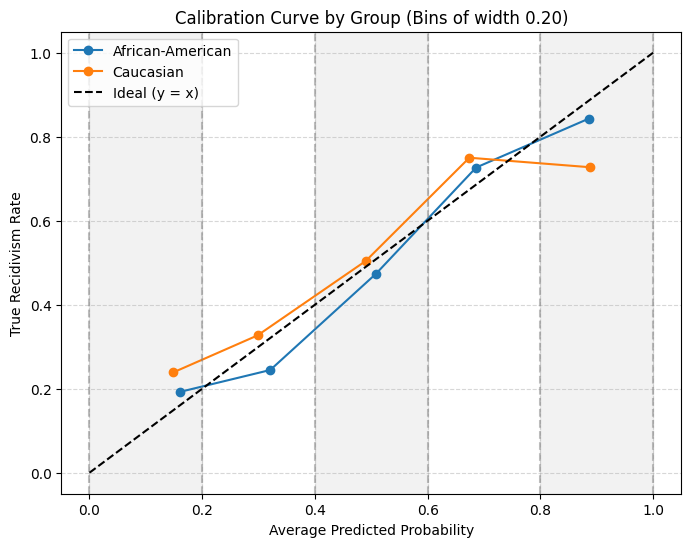

In [ ]:
#@title Run this to display the calibration curve for African-American and Caucasian defendants! {"display-mode":"form", "form-width":"25%"}
#@markdown Feel free to reveal the code and discuss if you're curious. As a bonus exercise, you can add in other groups to see what their curves look like!

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Number of bins; you can change this value as needed!
n_bins = 5

# Save a dictionary for every time we need to get a specific part of the data.
# This is helpful for the for loop later, and you can add more groups to this
# dictionary to plot more curves!
groups = {
  'African-American': X_test['African-American'] == 1,
  'Caucasian': X_test['Caucasian'] == 1
}


# Initialize the plot and add all the calibration curves
plt.figure(figsize=(8,6))

for group_name, mask in groups.items():
  # Get the predicted probabilities and true labels for this group
  y_pred_prob_group = model.predict_proba(X_test[mask])[:, 1]
  y_true_group = y_test[mask]

  # Compute calibration curve and plot
  true_recidivism_rates, avg_pred_probs = calibration_curve(
    y_true_group, y_pred_prob_group, n_bins=n_bins, strategy='uniform'
  )
  plt.plot(avg_pred_probs, true_recidivism_rates, marker='o', label=group_name)


# Plot bin shading and vertical lines after plotting curves for readability
bin_edges = np.linspace(0, 1, n_bins + 1)

for i in range(len(bin_edges) - 1):
  if i % 2 == 0:
    plt.axvspan(bin_edges[i], bin_edges[i+1], color='gray', alpha=0.1)

for edge in bin_edges:
  plt.axvline(edge, color='gray', linestyle='--', alpha=0.5)


# Plot y=x line
plt.plot([0, 1], [0, 1], 'k--', label='Ideal (y = x)')


# Finish up the plot and display
plt.xlabel('Average Predicted Probability')
plt.ylabel('True Recidivism Rate')
plt.title(f'Calibration Curve by Group (Bins of width {1/n_bins:.2f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Given the above plot, answer the following questions!

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}

#@markdown *1. From the graph above, we can see that the ideal calibration rate is the $y=x$ line. Think about why that is!*

#@markdown   *What does it mean when our calibration curves are over or under?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. How might such miscalibration affect real‑world decisions??*
answer_2 = "" # @param {"type":"string"}

#@markdown *3. What are the limitations of this definition? Is it the same as or different from group fairness?*
answer_3 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3)

Please input your responses in the answer boxes above!


## **1.3. Your Definition!**



Here's where you come in. You have two choices:

- Create your own definition that you want to test.
- OR select a new fairness definition from pages 3-5 [here](https://fairware.cs.umass.edu/papers/Verma.pdf)!
  - This paper analyzes a model predicting whether a person would have a good credit score, so the concepts should be similar to our analysis of a model predicting recidivism.
  - If you're confused by the mathematical notation in the paper, feel free to go back to the mathematical definitions of group fairness in the previous section. Understanding the mathematical notation shouldn't be necessary to understand the metrics in the paper though!
  - Group fairness is in section 3.1.1. of the paper, if you'd like to read through a familiar example to better understand the other metrics!
  - Other familiar metrics are positive predictive value (PPV), which we refer to as precision, and true positive rate (TPR), which we refer to as recall! False positive rate (FPR) is another metric that is interesting and easy to grasp.



### 1.3.1. *Discussion Exercise*

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. Write down a quick description of your fairness definition! It can just be the name if you chose one from the paper.*
answer_1 = "" # @param {"type":"string"}
#@markdown *2. Test the fairness of the model on your chosen definition in the code cell below. Retain the 25% threshold, or alternately, choose a new threshold AND justify your choice of new threshold. Briefly comment on your findings.*
answer_2 = "" # @param {"type":"string"}
#@markdown *3. Discuss what your new definition of threshold accomplishes that calibration and group fairness fail to do, and the limitations of your definition.*
answer_3 = "" # @param {"type":"string"}
#@markdown *4. Out of the fairness criteria we've explored in this notebook (including this one), which one would you choose to evaluate a model, and why?*
answer_4 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3, answer_4)

Please input your responses in the answer boxes above!


In [ ]:
### WRITE YOUR CODE BELOW: try creating and using a fairness metric to evaluate your model!



It should be apparent by this point that these disparate definitions of fairness capture different nuances of the model predictions -- they're measuring entirely different things, and yield entirely different results. Thus, the point of this exercise is to get you thinking not only about the mathematical evaluations we can use to answer this ethical problem, but also the *various value systems and assumptions* encoded within each definition of fairness.

So it was probably not too easy to come up with a mathematically AND sociologically sound definition of fairness. In fact, it can be [mathematically proven](https://arxiv.org/pdf/1609.05807v1.pdf) that the two fairness criterion we've explored above are not simultaneously satisfiable except for two narrow cases: a classifier with perfect accuracy, or equal base rates. There is an inherent tradeoff between the two. That's pretty depressing -- is there anything we can do?

Clearly, we're quite far from perfect accuracy. But what if we thought about the base rates? For that, we'll have to take a deeper look at the data itself.

---
---
# **📙 Milestone 2: Explainability**



Let's analyze this model from a different angle. Can we actually *explain*, from a human perspective, what features the model is looking at?

Another way we might think about whether a model is fair or not is by understanding how our classification model makes decisions. For example, if we can understand how our model maps inputs to its outputted classifications, we might be able to better assess if it is making decisions in a fair manner.



## **2.1. Perspectives**



Recently, the field of ***explainable AI (XAI)*** has explored how to make the complex decision-making models of machine learning algorithms more transparent and understandable to the humans who are interacting with them. Often times, as is likely the case with our recidivism algorithm, the people using the output of the algorithm for decision-making are not machine learning experts. XAI aims to help people understand why the algorithm came to the conclusion it did (in this case, why it predicted re-incarceration or not).


We will start by putting on different hats and imagining the perspectives of the different stakeholders who interact with our machine learning algorithm. What information do they need, and what information should we as the coders aim to provide?


### 2.1.1. *Discussion Exercise*

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. Imagine you are a judge who needs to use the algorithm's prediction to decide on a sentence for the defendant in a court case. What might you want to know about how the algorithm made its prediction if you want to be as fair as possible while keeping the community safe?*
answer_1 = "" # @param {"type":"string"}
#@markdown *2. Now imagine that you're the defendant, and the decision about your sentence is being influenced by the output of the algorithm. What information would you want the judge to know about how the algorithm made its prediction?*
answer_2 = "" # @param {"type":"string"}
#@markdown *3. Finally, imagine you're the coder who wrote the algorithm that predicts recidivism (as you did in the last notebook!). How would you describe to the judge how your logistic regression algorithm works?*
answer_3 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3)

Please input your responses in the answer boxes above!


Was it easy to describe your algorithm to the judge? I found it to be a little tricky. How might we explain what the algorithm was doing in a different way?

<!-- TODO: Add discussion of black box vs. white box. -->
You may have noticed that it's easier to understand and visualize some of the algorithms you've learned about so far than others.

***White box*** models are models that have inherently understandable input-output relationships for which the inner-workings of the algorithm are transparent. For example, think of a decision tree, which can be represented as a set of decision rules.

On the other hand, ***black box*** models are models for which the inner-workings are not as clear and for which there might be high non-linearities in the input-output relationships.


### 2.1.2 *Discussion Exercise*

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *Think of all the algorithms you've learned about during our time together. Which ones do you think would be considered "black box", and which ones would be considered "white box"?*
answer = "" # @param {"type":"string"}

handle_discussion_response(answer)

Please input your response in the answer box above!


Researchers are working on techniques to explain both "black box" and "white box" algorithms to people in a clearer way. So far, we've worked with a number of both "white box" and "black box" algorithms. Here we're going to explore how readily explainable, or interpretable, these algorithms are.

For "white box" algorithms, we can apply some basic explainability techniques to understand how the algorithm makes decisions.

One simple way of thinking about explainability  is called ***feature importance***. Feature importance techniques describe which features that the algorithm is using to learn have the most influence on the algorithm's decisions.

Now we're going to look at which input features are most important in predicting recidivism for different models!

## **2.2. Support Vector Machines (SVMs)**


First, we will consider linear SVMs. For linear models, such as SVMs, we can simply consider the coefficients that are learned during training to understand which features have the most influence on the output. As a reminder, a linear SVM model learns which line splits up the data into separate classes the best. The line is defined by:

$$y = w^{T}x + b$$

where $w^{T}$ represents the coefficients associated with each feature $x$. If you haven't seen this math before, don't worry! For now, we can assume that the larger the coefficient is, the more influence the associated feature has on the result.

First, we will train a linear SVM on our training data and use the learned coefficients to understand which factors of the input data had the greatest bearing on the prediction.

Run the code below to train a linear SVM on our training data.

In [ ]:
from sklearn import svm
from sklearn.svm import LinearSVC

# Create and train the SVM model
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train, y_train)

# Print the training and test accuracies
print("SVM Training accuracy:", model_svm.score(X_train, y_train))
print("SVM Testing accuracy:", model_svm.score(X_test, y_test))

SVM Training accuracy: 0.666558336041599
SVM Testing accuracy: 0.6537878787878788


Once you have trained your SVM, we can now explore which features have the most impact. A larger positive coefficient means that the corresponding feature influences the algorithm towards making a positive classification (recidivism), and a larger negative coeffient means that the corresponding feature influences the algorithm towards making a negative classification (no recidivism).

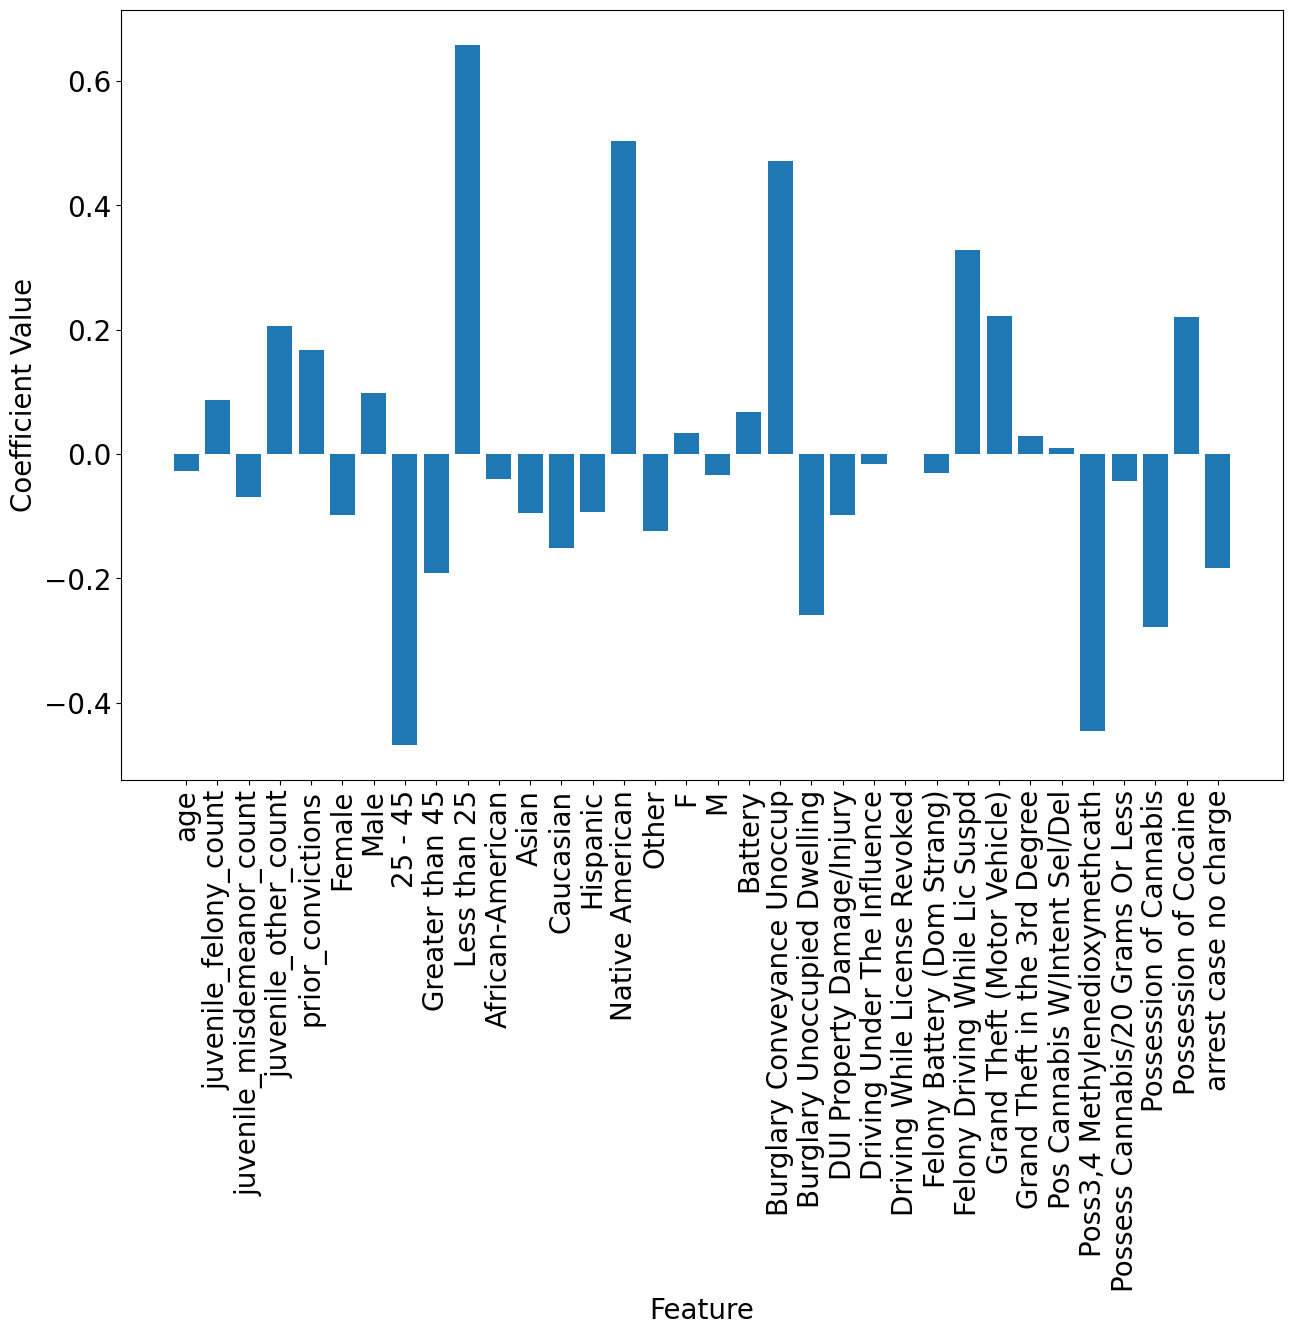

In [ ]:
# Get the model coefficients (feature importances)
importance_svm = model_svm.coef_[0]

# Plot the feature importances
features = X_all.columns
plt.rcParams['figure.figsize'] = [15, 10]
plt.xticks(rotation="vertical")
plt.gca().tick_params(axis='both', which='major', labelsize=20)

svm_importance_plot = plt.bar(features, importance_svm)
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Coefficient Value", fontsize=20)
plt.show()

Which features did you find were most important? How do you feel about this result? Were any of them protected?

No matter what result you found, being able to understand how our algorithm works allows us to ask questions about whether we agree with how it is making decisions. This gives us another tool to be able to check if the algorithm is exhibiting a bias that we find to be problematic.

Now let's say that we hope to build a model with improved accuracy. Here, we will first try a random forest and then a neural network. What can we know about the inner workings of each of these models?

## **2.3. Random Forests**



You don't need to fully understand how random forests work to implement one here! You can think of them as a collection of decision trees, where the classification that we make is based on how the decision trees "vote"

### *2.3.1. Coding Exercise*
Fill in the code below to train a random forest on our training data. You can try tuning the maximum depth of each tree (fill in the blank in the code) in the forest to get the best accuracy possible. What training and test accuracies result, and how do these compare with the SVM?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create and train the random forest classifier
model_rf = RandomForestClassifier(max_depth=____) # YOUR CODE HERE: Replace the blank!
model_rf.fit(X_train, y_train)

#Print training and test accuracies
print("Random Forest Training accuracy:", model_rf.score(____, ____)) # YOUR CODE HERE: Replace the blanks!
print("Random Forest Testing accuracy:", model_rf.score(____, ____)) # YOUR CODE HERE: Replace the blanks!

NameError: name '____' is not defined

Were you able to get a better accuracy than the SVM? Hopefully you were able to do at least a little better.

Now let's see what we can understand about how our random forest is making decisions. It's not quite as straightforward to understand how the random forest is using our input data to come up with a classification as it is with the linear SVM. Luckily, the programmers who wrote the random forest class that we are using have defined an attribute called feature_importances_, which we can use to explore our model.

For a random forest, the feature importances are calculated based on a metric called *impurity*. You can read more on impurity [here](https://victorzhou.com/blog/gini-impurity/).

Run the code below to find and plot the feature importances for our random forest. What do you find?

In [ ]:
#Get feature importances
rf_importances = model_rf.feature_importances_

#Plot feature importances
plt.xticks(rotation="vertical")
plt.gca().tick_params(axis='both', which='major', labelsize=20)
rf_importance_plot = plt.bar(features, rf_importances)
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Coefficient Value", fontsize=20)
plt.show()

Now let's zoom in on the set of features associated with race in particular. Run the code below to look at that part of the plot more closely. What do you see?

In [ ]:
#Create a list of importances associated with only the race-related variables
race_importances = rf_importances[10:16]
race_features = features[10:16]

#Plot feature importances related to race
plt.gca().tick_params(axis='both', which='major', labelsize=18)
race_importances_plot = plt.bar(race_features, race_importances)
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Coefficient Value", fontsize=20)
plt.show()

Even though we have a higher accuracy with our new model, there seem to be some worrying trends in terms of which features the model considers to be important in making its classifications.


## **2.4. Neural Networks**


### *2.4.1. Coding Exercise*

Fill in the code below to train a neural network on our training data. You can try tuning the number of layers and the size of the layers (left as blanks in the code below to start) to get the best accuracy possible, just as we have done in previous notebooks. What training and test accuracies can you get using a neural network? How do these compare to the other two models?

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create and train the neural network
model_nn = MLPClassifier(hidden_layer_sizes=(____, ____, ____),random_state=1, max_iter=500) ### YOUR CODE HERE: replace the blanks with your architecture!
model_nn.fit(X_train, y_train)

# Print training and test accuracies
print("Neural Network Training accuracy:", model_nn.score(X_train, y_train))
print("Neural Network Testing accuracy:", model_nn.score(X_test, y_test))

Now, how can we go about understanding the neural network? We could try to look at the coefficients that the network has learned as we did with the linear SVM. But what do these coefficients mean in this case? It's less clear how they relate to the inputs.

Machine learning researchers refer to the dilemma we just encountered as the **interpretability-accuracy trade-off**. Oftentimes, higher-performing machine learning models (in terms of accuracy) are more difficult to directly interpret. This is usually because they are more complex and can model the data better, but in a way that humans can't easily visualize or understand.

Just as researchers devloped a way to define feature importance for random forests, researchers are working on way to understand neural networks better. So far, we do not have a clear and unified way of thinking about how to interpet neural networks (and many other machine learning techniques!).

Now consider our algorithm again. The decision it is making influences whether someone goes to jail or not. Do you think it is more important to have an algorithm that is interpretable or accurate in this case? Would you be willing to give up the ability to easily understand what the algorithm is doing for better predictive performance?

---
---
# **Conclusion**

Well done! You've taken apart the biased COMPAS model we trained in the previous notebook and analyzed it along the lines of fairness and explainability. Hopefully, this has helped you develop a decent sense of how model bias works.

In the final notebook, we'll be using these insights to try and create a better model. We'll also encourage you to think about some other datasets in the wild and consider how biases might also creep into those models.